In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import seaborn as sns
import os
import os.path as osp
import sys
import pickle
import joblib
from collections import Counter
from itertools import product
import torch
import pdb
import random
import tables
from sklearn.linear_model import LogisticRegression, LinearRegression
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, average_precision_score,\
balanced_accuracy_score
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.calibration import CalibratedClassifierCV
import heckman
from heckman import Heckman

In [2]:
SEED=90210
np.random.seed(SEED)

In [3]:
os.environ['USER_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/'
os.environ['OUT_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory'

In [4]:
open_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', 'stop_and_frisk.pkl')
with open(f"{open_path}", "rb") as input_file:
    dict_raw_sf= pickle.load(input_file)
df_raw_sf = dict_raw_sf['stops']

In [5]:
df_raw_sf

,year,date,time,precinct,xcoord,ycoord,serial,radio.run,inside.outside,location.housing,...,suspect.height,suspect.weight,suspect.hair,suspect.eye,suspect.build,found.gun,found.weapon,id,lat,lon
0,2006,NaN,NaN,NaN,1006611,233503,NaN,False,NaN,neither,...,5.583333,160,black,brown,medium,False,False,2,40.807559,-73.919226
1,2006,2006-01-01,14:10,1,981738,198272,1,False,True,transit,...,6.083333,155,black,brown,thin,False,False,3,40.710887,-74.009061
2,2006,2006-01-01,08:50,1,981349,198508,2,False,True,transit,...,5.666667,180,brown,brown,medium,False,False,4,40.711535,-74.010464
3,2006,2006-01-02,17:00,1,982103,198029,3,False,True,transit,...,5.583333,170,black,black,medium,False,False,5,40.710220,-74.007744
4,2006,2006-01-01,20:10,1,983359,203119,4,True,True,neither,...,5.666667,200,brown,brown,medium,False,False,6,40.724191,-74.003215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086141,2013,2013-12-31,23:20,45,1032876,2,1160,False,False,housing,...,6.083333,198,black,brown,medium,False,False,4111824,40.166540,-73.826025
4086142,2013,2013-12-31,23:37,9,987234,2,2338,False,False,neither,...,5.500000,220,black,black,medium,False,True,4111825,40.166672,-73.989324
4086143,2013,2013-12-31,23:50,49,1022168,2,1645,False,False,neither,...,5.750000,150,black,brown,medium,False,False,4111826,40.166592,-73.864336
4086144,2013,2013-12-31,23:50,49,1022168,2,1647,False,False,neither,...,5.833333,215,black,brown,medium,False,False,4111827,40.166592,-73.864336


## filter the dataframe for years between 2008 and 2012

In [6]:
years=[2008, 2009, 2010, 2011]
df_raw_sf=df_raw_sf.loc[df_raw_sf[['year']].apply(lambda x: x.isin(years)).values].reset_index(drop=True)

In [7]:
df_raw_sf.describe()

,year,observation.period,suspect.age,suspect.height,id,lat,lon
count,2.395847e+06,2.395847e+06,2.395847e+06,2.395847e+06,2.395847e+06,2.315618e+06,2.315618e+06
mean,2.009595e+03,2.520337e+00,2.802747e+01,5.716220e+00,2.183050e+06,4.072874e+01,-7.391977e+01
std,1.121900e+00,5.845748e+00,1.149359e+01,2.678002e-01,6.951285e+05,8.014419e-02,7.583827e-02
min,2.008000e+03,0.000000e+00,1.000000e+01,3.000000e+00,9.785880e+05,4.049805e+01,-7.425525e+01
25%,2.009000e+03,1.000000e+00,1.900000e+01,5.583333e+00,1.581292e+06,4.067016e+01,-7.395512e+01
50%,2.010000e+03,1.000000e+00,2.400000e+01,5.750000e+00,2.183052e+06,4.071153e+01,-7.392233e+01
75%,2.011000e+03,2.000000e+00,3.400000e+01,5.916667e+00,2.785018e+06,4.080349e+01,-7.388080e+01
max,2.011000e+03,9.990000e+02,8.000000e+01,7.916667e+00,3.387066e+06,4.091289e+01,-7.370047e+01


In [8]:
df_raw_sf.iloc[10]

year                  2008
date            2008-01-25
time                 22:25
precinct                73
xcoord             1009977
                   ...    
found.gun            False
found.weapon         False
id                  978599
lat              40.667579
lon             -73.907262
Name: 10, Length: 89, dtype: object

## drop na for suspect.race, suspect.sex

In [10]:
print(f" number of rows with suspect.race value as nan:{df_raw_sf['suspect.race'].isna().sum()}")
print(f" number of rows with suspect.sex value as nan:{df_raw_sf['suspect.sex'].isna().sum()}")
# drop these columns
df_raw_sf=df_raw_sf.loc[~df_raw_sf['suspect.race'].isna()]
df_raw_sf=df_raw_sf.loc[~df_raw_sf['suspect.sex'].isna()]
print(f" number of rows with time value as nan:{df_raw_sf['time'].isna().sum()}")
print(f" number of rows with date value as nan:{df_raw_sf['date'].isna().sum()}")
# drop these columns
df_raw_sf=df_raw_sf.loc[~df_raw_sf['time'].isna()]
print(f" number of rows with suspect.hair value as nan:{df_raw_sf['suspect.hair'].isna().sum()}")
print(f" number of rows with suspected.crime value as nan:{df_raw_sf['suspected.crime'].isna().sum()}")
df_raw_sf=df_raw_sf.loc[~df_raw_sf['suspect.hair'].isna()]
df_raw_sf=df_raw_sf.loc[~df_raw_sf['suspected.crime'].isna()]
print(f" number of rows with suspect.weight value as nan:{df_raw_sf['suspect.weight'].isna().sum()}")
df_raw_sf=df_raw_sf.loc[~df_raw_sf['suspect.weight'].isna()]

 number of rows with suspect.race value as nan:16777
 number of rows with suspect.sex value as nan:40323
 number of rows with time value as nan:382
 number of rows with date value as nan:382
 number of rows with suspect.hair value as nan:2803
 number of rows with suspected.crime value as nan:49
 number of rows with suspect.weight value as nan:1637


## bin age in  [0, 18, 25, 32, 40, np.inf] bins

In [11]:
df_raw_sf["suspect.age"] = pd.cut(df_raw_sf["suspect.age"], bins=[0, 18, 25, 32, 40, np.inf])

## form two new columns month and hour from date and time respectively

In [12]:
df_raw_sf['time']=df_raw_sf['time'].apply(lambda x: datetime.strptime(str(x),  "%H:%M"))
df_raw_sf['date']=df_raw_sf['date'].apply(lambda x: datetime.strptime(str(x),  "%Y-%m-%d"))
df_raw_sf['month'] = df_raw_sf['date'].apply(lambda x: x.month)
df_raw_sf['hour'] = df_raw_sf['time'].apply(lambda x: x.hour)

In [13]:
# replace the race names per dict
race_dict={'black':'Black', 'black hispanic':'Hispanic', 'white':'White', 'white hispanic':'Hispanic'}
df_raw_sf=df_raw_sf.replace({"suspect.race": race_dict})

In [14]:
categories=['Black', 'Hispanic', 'White']
df_raw_sf = df_raw_sf.loc[df_raw_sf['suspect.race'].isin(categories)]

In [15]:
df_raw_sf.groupby("year")[["frisked", "found.weapon"]].agg(['sum','count'])

frisked         found.weapon        
         sum   count          sum   count
year                                     
2008  271494  494495         6192  494495
2009  307784  537882         6860  537882
2010  314049  552720         7159  552720
2011  353828  627987         7335  627987

In [16]:
# To define the T column, T = 1 if frisked.bc.weapons = 1. 
# To define D, D = 1 if (frisked.bc.weapons & found.weapon) = 1.
# In other words, the test decision is to search for weapons, and the test is positive if the officer finds weapons.

In [17]:
# use and cite WILDS with this github repo page 
# https://github.com/p-lambda/wilds/blob/472677590de351857197a9bf24958838c39c272b/wilds/datasets/sqf_dataset.py
# use and cite fastt with this githup 
# https://github.com/5harad/fasttt/blob/master/data_processing.R

In [18]:
def get_split_features(columns):
    """Get features from "https://github.dev/stanford-policylab/risk-adjusted-regression/tree/master/src"""
    feats_to_use = []
    feats_to_use += ["suspect.race",
  "suspected.crime",
  "year",
  "month",
  "hour",
  "precinct",
  "location.housing",
  "suspect.sex",
  "suspect.age",
  "suspect.height",
  "suspect.weight",
  "suspect.hair",
  "suspect.eye",
  "suspect.build",
  "additional.report",
  "additional.investigation",
  "additional.proximity",
  "additional.evasive",
  "additional.associating",
  "additional.direction",
  "additional.highcrime",
  "additional.time",
  "additional.sights",
  "additional.other",
  "stopped.bc.object",
  "stopped.bc.desc",
  "stopped.bc.casing",
  "stopped.bc.lookout",
  "stopped.bc.clothing",
  "stopped.bc.drugs",
  "stopped.bc.furtive",
  "stopped.bc.violent",
  "stopped.bc.bulge",
  "stopped.bc.other"]
    return feats_to_use

In [19]:
df_raw_sf['T']=df_raw_sf['frisked']
df_raw_sf['D']=df_raw_sf['found.weapon']

In [20]:
df_raw_sf.groupby(['T', 'D'])['id'].describe()

count          mean            std       min         25%  \
T     D                                                                     
False False   964245.0  2.174490e+06  699914.632665  978589.0  1564520.00   
      True      1684.0  2.269702e+06  667272.625109  978806.0  1722220.75   
True  False  1221293.0  2.188759e+06  689845.048987  978588.0  1598209.00   
      True     25862.0  2.159603e+06  681127.156531  978628.0  1572639.00   

                   50%         75%        max  
T     D                                        
False False  2174624.0  2786437.00  3387061.0  
      True   2331623.0  2830765.75  3386673.0  
True  False  2184756.0  2781628.00  3387066.0  
      True   2156164.5  2730445.50  3386674.0

## mark D as missing (NA) when T==0

In [10]:
df_raw_sf.loc[df_raw_sf['T']==0,'D']=np.nan
df_raw_sf.groupby(['T', 'D'])['id'].describe()

KeyError: 'T'

In [22]:
df_raw_sf.loc[df_raw_sf['T']==0,'D']

1         NaN
4         NaN
5         NaN
6         NaN
7         NaN
           ..
2395830   NaN
2395833   NaN
2395837   NaN
2395839   NaN
2395841   NaN
Name: D, Length: 965929, dtype: float64

In [23]:
df_raw_sf["suspect.race"].unique()

array(['Black', 'Hispanic', 'White'], dtype=object)

In [24]:
feats_to_use=get_split_features(df_raw_sf.columns)

In [25]:
df_raw_sf[feats_to_use]

,suspect.race,suspected.crime,year,month,hour,precinct,location.housing,suspect.sex,suspect.age,suspect.height,...,stopped.bc.object,stopped.bc.desc,stopped.bc.casing,stopped.bc.lookout,stopped.bc.clothing,stopped.bc.drugs,stopped.bc.furtive,stopped.bc.violent,stopped.bc.bulge,stopped.bc.other
0,Black,cpw,2008,1,1,42,neither,male,"(18.0, 25.0]",6.000000,...,False,True,False,False,False,False,True,False,False,True
1,Hispanic,burglary,2008,1,20,108,neither,male,"(18.0, 25.0]",5.583333,...,False,False,False,False,False,False,False,False,False,True
2,Black,robbery,2008,1,1,100,housing,male,"(0.0, 18.0]",6.000000,...,False,True,False,False,False,False,False,False,False,False
3,Black,robbery,2008,1,19,103,neither,male,"(18.0, 25.0]",6.083333,...,False,False,False,True,False,False,True,False,False,False
4,Black,criminal trespass,2008,1,21,71,housing,male,"(0.0, 18.0]",5.750000,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395842,Hispanic,cpw,2011,12,23,115,neither,male,"(18.0, 25.0]",5.500000,...,False,False,False,False,False,False,True,True,False,False
2395843,Black,cpw,2011,12,23,23,housing,male,"(18.0, 25.0]",5.750000,...,False,False,False,False,False,False,True,False,False,False
2395844,Black,cpw,2011,12,23,40,neither,male,"(18.0, 25.0]",5.750000,...,False,False,False,False,False,False,True,False,False,False
2395845,Black,cpw,2011,12,23,40,neither,male,"(18.0, 25.0]",5.833333,...,False,False,False,False,False,False,True,False,False,False


In [26]:
df_raw_sf[feats_to_use].iloc[1]

suspect.race                    Hispanic
suspected.crime                 burglary
year                                2008
month                                  1
hour                                  20
precinct                             108
location.housing                 neither
suspect.sex                         male
suspect.age                 (18.0, 25.0]
suspect.height                  5.583333
suspect.weight                       190
suspect.hair                       brown
suspect.eye                        brown
suspect.build                      heavy
additional.report                  False
additional.investigation           False
additional.proximity                True
additional.evasive                 False
additional.associating             False
additional.direction               False
additional.highcrime               False
additional.time                    False
additional.sights                  False
additional.other                   False
stopped.bc.objec

In [27]:
cat_cols = ['suspect.race', 'suspected.crime', 'year', 'month', 'hour', 'precinct',
                     'location.housing', 'suspect.sex', 'suspect.age', 'suspect.hair', 'suspect.eye',
                     'suspect.build']
df_raw_sf[cat_cols].astype('object').describe()

,suspect.race,suspected.crime,year,month,hour,precinct,location.housing,suspect.sex,suspect.age,suspect.hair,suspect.eye,suspect.build
count,2213084,2213084,2213084,2213084,2213084,2213084,2213084,2213084,2213084,2213084,2213084,2213084
unique,3,108,4,12,24,76,3,2,5,13,12,5
top,Black,cpw,2011,1,22,75,neither,male,"(18.0, 25.0]",black,brown,medium
freq,1236755,595091,627987,206637,175315,109529,1697566,2059163,740721,1664449,1982430,1325295


In [28]:
df_raw_sf["suspected.crime"].unique()

['cpw', 'burglary', 'robbery', 'criminal trespass', 'criminal sale of controlled substance', ..., 'substitution of children', 'abortion', 'fraudulent make electronic access device', 'tampering with private communications', 'rent gouging']
Length: 108
Categories (108, object): ['cpw', 'burglary', 'robbery', 'criminal trespass', ..., 'abortion', 'fraudulent make electronic access device', 'tampering with private communications', 'rent gouging']

In [29]:
cens_feats =[
  "suspect.race",
  "location.housing",
  "suspected.crime",
  "precinct",
  "suspect.sex",
  "suspect.age"
]
for f in cat_cols:
    print(f" values for {f}: {df_raw_sf[f].unique()}")

 values for suspect.race: ['Black' 'Hispanic' 'White']
 values for suspected.crime: ['cpw', 'burglary', 'robbery', 'criminal trespass', 'criminal sale of controlled substance', ..., 'substitution of children', 'abortion', 'fraudulent make electronic access device', 'tampering with private communications', 'rent gouging']
Length: 108
Categories (108, object): ['cpw', 'burglary', 'robbery', 'criminal trespass', ..., 'abortion', 'fraudulent make electronic access device', 'tampering with private communications', 'rent gouging']
 values for year: [2008 2009 2010 2011]
 values for month: [ 1  2  3  4  5  6  7  8  9 10 11 12]
 values for hour: [ 1 20 19 21 22 18  5  9 23 16  2  0 13  3 11 15 10 14 17 12  4  6  7  8]
 values for precinct: ['42', '108', '100', '103', '71', ..., '66', '61', '78', '41', '22']
Length: 76
Categories (76, object): ['42', '108', '100', '103', ..., '61', '78', '41', '22']
 values for location.housing: ['neither', 'housing', 'transit']
Categories (3, object): ['neithe

In [30]:
df_raw_sf=df_raw_sf[feats_to_use+['T', 'D']]

In [31]:
idxs = np.arange(len(df_raw_sf))
train_idxs = np.random.choice(idxs, size=int(len(df_raw_sf)*0.5), replace=False)
test_idxs = np.setdiff1d(idxs, train_idxs)
assert len(np.intersect1d(train_idxs, test_idxs))==0

In [32]:
def get_split_maps(data_df,  train_idxs, test_idxs, val_idxs=None):
    """Using the existing split indices, create a map to put entries to training and validation sets. """
    split_array = np.zeros(data_df.shape[0])
    split_array[train_idxs] = 0
    split_array[test_idxs] = 1
    if val_idxs is not None:
        split_array[val_idxs] = 2
    return split_array

In [33]:
split_array=get_split_maps(df_raw_sf,  train_idxs, test_idxs)
split_array[split_array==0].shape, split_array[split_array==1].shape

((1106542,), (1106542,))

In [34]:
def normalize_data(df,  train_idxs):
    """"Normalizes the data as Goel et al do - continuous features only"""
    columns_to_norm = ['suspect.height', 'suspect.weight']
    df_unnormed_train = df.iloc[train_idxs].copy()
    for feature_name in columns_to_norm:
        df[feature_name] = df[feature_name] - np.mean(df_unnormed_train[feature_name])
        df[feature_name] = df[feature_name] / np.std(df_unnormed_train[feature_name])
    return df, np.mean(df_unnormed_train[feature_name]), np.std(df_unnormed_train[feature_name])

In [35]:
df_raw_sf, mean, std=normalize_data(df_raw_sf,  train_idxs)

In [36]:
columns_to_ohe = ['suspect.race', 'suspected.crime', 'year', 'month', 'hour', 'precinct',
                     'location.housing', 'suspect.sex', 'suspect.age', 'suspect.hair', 'suspect.eye',
                     'suspect.build']
for f in columns_to_ohe:
    ohe_df=pd.get_dummies(df_raw_sf[f], prefix=f, drop_first=True)
    df_raw_sf=df_raw_sf.drop(f, axis=1)
    df_raw_sf=df_raw_sf.join(ohe_df.astype('bool'))

In [37]:
df_raw_sf

,suspect.height,suspect.weight,additional.report,additional.investigation,additional.proximity,additional.evasive,additional.associating,additional.direction,additional.highcrime,additional.time,...,suspect.eye_maroon,suspect.eye_other,suspect.eye_pink,suspect.eye_two different,suspect.eye_unknown,suspect.eye_violet,suspect.build_medium,suspect.build_muscular,suspect.build_thin,suspect.build_unknown
0,1.051161,-0.278776,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,-0.510868,0.694381,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.051161,0.35881,True,False,True,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,1.363566,0.526596,False,False,False,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
4,0.113943,-0.815691,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395842,-0.823274,0.35881,False,True,False,False,False,True,True,True,...,False,False,False,False,False,False,True,False,False,False
2395843,0.113943,-0.312333,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2395844,0.113943,1.029953,False,False,True,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False
2395845,0.426349,1.029953,False,False,True,False,False,False,True,True,...,False,False,False,False,False,False,True,False,False,False


In [38]:
features=[]
for c in df_raw_sf.columns:
    if c not in ['T', 'D', 'D_and_T']:
        features.append(c)

In [39]:
for c in features:
    assert df_raw_sf[c].isna().sum()==0

In [40]:
train_X=df_raw_sf.iloc[train_idxs][features].reset_index(drop=True)
test_X = df_raw_sf.iloc[test_idxs][features].reset_index(drop=True)
test_y_T = df_raw_sf.iloc[test_idxs]['T'].values
train_y_T = df_raw_sf.iloc[train_idxs]['T'].values

train_X_D_given_T=df_raw_sf.iloc[train_idxs].loc[df_raw_sf['T']==1][features].reset_index(drop=True)
test_X_D_given_T=df_raw_sf.iloc[test_idxs].loc[df_raw_sf['T']==1][features].reset_index(drop=True)

test_y_D_given_T = df_raw_sf.iloc[test_idxs].loc[df_raw_sf['T']==1]['D'].values
train_y_D_given_T = df_raw_sf.iloc[train_idxs].loc[df_raw_sf['T']==1]['D'].values

df_raw_sf['D_and_T']=(df_raw_sf['T']==1) & (df_raw_sf['D']==1)
test_y_D_and_T = df_raw_sf.iloc[test_idxs]['D_and_T'].values
train_y_D_and_T = df_raw_sf.iloc[train_idxs]['D_and_T'].values

In [41]:
train_y_D = df_raw_sf.iloc[test_idxs]['D'].values

In [42]:
np.array(train_X).shape

(1106542, 282)

In [43]:
np.array(train_X)

array([[-0.19846230363826883, 0.35880991432541354, False, ..., False,
        False, False],
       [-0.19846230363826883, -0.48011899415839676, True, ..., False,
        False, False],
       [-1.1356795656177727, -1.3526050589815595, True, ..., False,
        False, False],
       ...,
       [-0.19846230363826883, -0.3123332124616347, False, ..., False,
        False, False],
       [0.11394345035489802, -0.6479047758551588, False, ..., False,
        True, False],
       [1.3635664663275686, 1.0299530411124618, False, ..., False, False,
        False]], dtype=object)

In [42]:
# save train and test X, y
def saveFile(filename, file):
    save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk')
    with open(osp.join(save_path, filename), "wb") as output_file:
        pickle.dump(file, output_file)

saveFile(filename='train_X.pkl', file=train_X)
saveFile(filename='train_X_D_given_T.pkl', file=train_X_D_given_T)
saveFile(filename='train_y_T.pkl', file=train_y_T)
saveFile(filename='train_y_D_given_T.pkl', file=train_y_D_given_T)
saveFile(filename='train_y_D_and_T.pkl', file=train_y_D_and_T)        

saveFile(filename='test_X.pkl', file=test_X)
saveFile(filename='test_X_D_given_T.pkl', file=test_X_D_given_T)
saveFile(filename='test_y_T.pkl', file=test_y_T)
saveFile(filename='test_y_D_given_T.pkl', file=test_y_D_given_T)
saveFile(filename='test_y_D_and_T.pkl', file=test_y_D_and_T) 
saveFile(filename='df_sf.pkl', file=df_raw_sf) 
saveFile(filename='test_idxs.pkl', file=test_idxs)
saveFile(filename='features.pkl', file=features)

In [44]:
def saveModel(save_path, model, filename):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    with open(osp.join(save_path, filename), "wb") as output_file:
        pickle.dump(model, output_file)

In [45]:
def trainEvalModel(model, train_X, train_y, test_X, test_y, model_descr):
    clf=model.fit(train_X, train_y)
    test_proba = model.predict_proba(test_X)
    print(f"AUC score {model_descr}: {roc_auc_score(test_y, test_proba[:,1]):.3f}")
    return clf

## Sensitivity to Regularization for LR models

In [44]:
tol=0.01
l1_ratio = 0.5  # L1 weight in the Elastic-Net regularization
for C in [0.01,0.1,1.0]:
    # predicting T
    model_descr=f"predict T with l1 penalty for C:{C}"
    clf_T_lr_l1=trainEvalModel(LogisticRegression(random_state=0, solver='saga', penalty= 'l1', C=C, tol=0.01), 
                np.array(train_X), train_y_T, np.array(test_X), np.array(test_y_T), model_descr)
    save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', f"C_{C}_tol_{tol}")
    saveModel(save_path, clf_T_lr_l1, 'clf_T_lr_l1.pkl')
    
    model_descr=f"predict T with l2 penalty for C:{C}"
    clf_T_lr_l2=trainEvalModel(LogisticRegression(random_state=0, solver='saga', penalty= 'l2', C=C, tol=0.01), 
                np.array(train_X), train_y_T, np.array(test_X), np.array(test_y_T), model_descr)
    save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', f"C_{C}_tol_{tol}")
    saveModel(save_path, clf_T_lr_l2, 'clf_T_lr_l2.pkl')
    
    model_descr=f"predict T with elastic_net penalty for C:{C} and l1_ratio_{l1_ratio}"
    clf_T_lr_en=trainEvalModel(LogisticRegression(random_state=0, solver='saga', penalty= 'elasticnet', C=C, tol=0.01, l1_ratio=l1_ratio), 
                np.array(train_X), train_y_T, np.array(test_X), np.array(test_y_T), model_descr)
    save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', f"C_{C}_tol_{tol}_en_l1_ratio_{l1_ratio}")
    saveModel(save_path, clf_T_lr_en, 'clf_T_lr_en.pkl')
    
    # predicting D|T
    model_descr=f"predict D|T with l1 penalty for C:{C}"
    clf_D_given_T_lr_l1=trainEvalModel(LogisticRegression(random_state=0, solver='saga', penalty= 'l1', C=C, tol=0.01), 
                np.array(train_X_D_given_T), train_y_D_given_T, np.array(test_X_D_given_T), 
                np.array(test_y_D_given_T), model_descr)
    save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', f"C_{C}_tol_{tol}")
    saveModel(save_path, clf_D_given_T_lr_l1, 'clf_D_given_T_lr_l1.pkl')
    
    model_descr=f"predict D|T with l2 penalty for C:{C}"
    clf_D_given_T_lr_l2=trainEvalModel(LogisticRegression(random_state=0, solver='saga', penalty= 'l2', C=C, tol=0.01), 
                np.array(train_X_D_given_T), train_y_D_given_T, np.array(test_X_D_given_T), 
                np.array(test_y_D_given_T), model_descr)
    save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', f"C_{C}_tol_{tol}")
    saveModel(save_path, clf_D_given_T_lr_l2, 'clf_D_given_T_lr_l2.pkl')
    
    model_descr=f"predict D|T with elastic_net penalty for C:{C} and l1_ratio_{l1_ratio}"
    clf_D_given_T_lr_en=trainEvalModel(LogisticRegression(random_state=0, solver='saga', penalty= 'elasticnet', C=C, tol=0.01, l1_ratio=l1_ratio), 
                np.array(train_X_D_given_T), train_y_D_given_T, np.array(test_X_D_given_T), 
                np.array(test_y_D_given_T), model_descr)
    save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', f"C_{C}_tol_{tol}_en_l1_ratio_{l1_ratio}")
    saveModel(save_path, clf_D_given_T_lr_en, 'clf_D_given_T_lr_en.pkl')
    
    # predicting D and T
    model_descr=f"predict D,T with l1 penalty for C:{C}"
    clf_D_and_T_lr_l1=trainEvalModel(LogisticRegression(random_state=0, solver='saga', penalty= 'l1', C=C, tol=0.01), 
                np.array(train_X), train_y_D_and_T, np.array(test_X), 
                np.array(test_y_D_and_T), model_descr)
    save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', f"C_{C}_tol_{tol}")
    saveModel(save_path, clf_D_and_T_lr_l1, 'clf_D_and_T_lr_l1.pkl')
    
    model_descr=f"predict D,T with l2 penalty for C:{C}"
    clf_D_and_T_lr_l2=trainEvalModel(LogisticRegression(random_state=0, solver='saga', penalty= 'l2', C=C, tol=0.01), 
                np.array(train_X), train_y_D_and_T, np.array(test_X), 
                np.array(test_y_D_and_T), model_descr)
    save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', f"C_{C}_tol_{tol}")
    saveModel(save_path, clf_D_and_T_lr_l2, 'clf_D_and_T_lr_l2.pkl')
    
    model_descr=f"predict D,T with elastic_net penalty for C:{C} and l1_ratio_{l1_ratio}"
    clf_D_and_T_lr_en=trainEvalModel(LogisticRegression(random_state=0, solver='saga', penalty= 'elasticnet', C=C, tol=0.01, l1_ratio=l1_ratio),
                np.array(train_X), train_y_D_and_T, np.array(test_X), 
                np.array(test_y_D_and_T), model_descr)
    save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', f"C_{C}_tol_{tol}_en_l1_ratio_{l1_ratio}")
    saveModel(save_path, clf_D_and_T_lr_en, 'clf_D_and_T_lr_en.pkl')

AUC score predict T with l1 penalty for C:0.01: 0.817
AUC score predict T with l2 penalty for C:0.01: 0.817
AUC score predict T with elastic_net penalty for C:0.01 and l1_ratio_0.5: 0.817
AUC score predict D|T with l1 penalty for C:0.01: 0.787
AUC score predict D|T with l2 penalty for C:0.01: 0.797
AUC score predict D|T with elastic_net penalty for C:0.01 and l1_ratio_0.5: 0.792
AUC score predict D,T with l1 penalty for C:0.01: 0.833
AUC score predict D,T with l2 penalty for C:0.01: 0.841
AUC score predict D,T with elastic_net penalty for C:0.01 and l1_ratio_0.5: 0.837
AUC score predict T with l1 penalty for C:0.1: 0.818
AUC score predict T with l2 penalty for C:0.1: 0.818
AUC score predict T with elastic_net penalty for C:0.1 and l1_ratio_0.5: 0.818
AUC score predict D|T with l1 penalty for C:0.1: 0.801
AUC score predict D|T with l2 penalty for C:0.1: 0.802
AUC score predict D|T with elastic_net penalty for C:0.1 and l1_ratio_0.5: 0.801
AUC score predict D,T with l1 penalty for C:0.1:

## p(T=1|Race, $\mu$)

In [45]:
clf_D_given_T_lgbm = LGBMClassifier(random_state=0).fit(np.array(train_X_D_given_T), train_y_D_given_T)
test_y_D_given_T_proba=clf_D_given_T_lgbm.predict_proba(np.array(test_X_D_given_T))
print(f"AUC score with lgbm: {roc_auc_score(np.array(test_y_D_given_T), test_y_D_given_T_proba[:,1])}")
mu_test = clf_D_given_T_lgbm.predict_proba(np.array(test_X))[:,1]
mu_train = clf_D_given_T_lgbm.predict_proba(np.array(train_X))[:,1]

AUC score with lgbm: 0.8220645044692207


In [46]:
print(f"AUC score for T_given_mu test: {roc_auc_score(np.array(test_y_T), mu_test)}")
print(f"AUC score for T_given_mu train: {roc_auc_score(np.array(train_y_T), mu_train)}")

AUC score for T_given_mu test: 0.6081310814233466
AUC score for T_given_mu train: 0.6093704416195945


In [47]:
clf_T_given_mu_lgbm = LGBMClassifier(random_state=0).fit(mu_train.reshape(-1,1), train_y_T)
test_T_given_mu = clf_T_given_mu_lgbm.predict_proba(mu_test.reshape(-1,1))
print(f"AUC score for T_given_mu test with link function : {roc_auc_score(np.array(test_y_T), test_T_given_mu[:,1])}")

AUC score for T_given_mu test with link function : 0.6211224832010882


In [48]:
mu_train.shape

(1106542,)

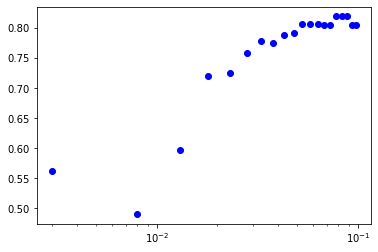

In [49]:
for x in np.arange(0.003,0.1,0.005):
    plt.scatter(x, clf_T_given_mu_lgbm.predict_proba(np.array(x)[None,None])[:,1], c='b')
plt.xscale('log')
plt.show()
plt.close()

In [50]:
clf_T_lgbm = LGBMClassifier(random_state=0).fit(np.array(train_X), train_y_T)
test_y_T_proba=clf_T_lgbm.predict_proba(np.array(test_X))
print(f"AUC score with lgbm: {roc_auc_score(np.array(test_y_T), test_y_T_proba[:,1])}")

AUC score with lgbm: 0.8325733842822723


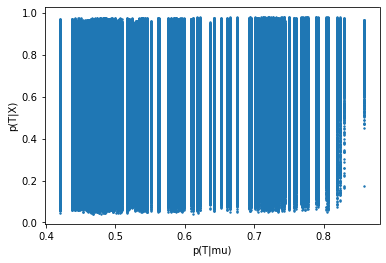

SpearmanrResult(correlation=0.3632150049201078, pvalue=0.0)


In [51]:
plt.scatter(test_T_given_mu[:,1],  test_y_T_proba[:,1], s=2)
plt.xlabel('p(T|mu)')
plt.ylabel('p(T|X)')
plt.show()
plt.close()
print(stats.spearmanr(test_T_given_mu[:,1],  test_y_T_proba[:,1]))

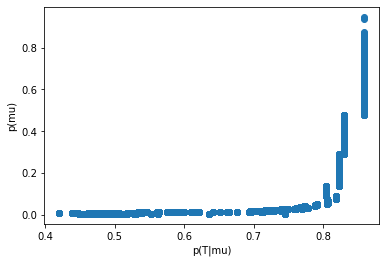

SpearmanrResult(correlation=0.7562130728634376, pvalue=0.0)


In [52]:
plt.scatter(test_T_given_mu[:,1],  mu_test)
plt.xlabel('p(T|mu)')
plt.ylabel('p(mu)')
plt.show()
plt.close()
print(stats.spearmanr(test_T_given_mu[:,1],  mu_test))

##  p(T=1) estimator

In [46]:
clf_T_lr = LogisticRegression(random_state=0, solver='liblinear', penalty= 'l1')
clf_T_lr=CalibratedClassifierCV(clf_T_lr)
clf_T_lr=clf_T_lr.fit(np.array(train_X), train_y_T)
test_y_T_proba=clf_T_lr.predict_proba(np.array(test_X))
print(f"AUC score: {roc_auc_score(np.array(test_y_T), test_y_T_proba[:,1])}")

save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', 'clf_T_lr.pkl')


AUC score: 0.8175524029076543


In [47]:
train_X_T_probs_lr = clf_T_lr.predict_proba(np.array(train_X_D_given_T))[:,1]
epsilon=0.05
train_X_T_probs_lr=np.clip(train_X_T_probs_lr, a_min=epsilon, a_max=1-epsilon)

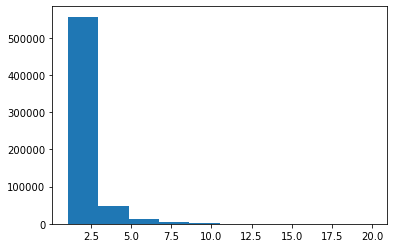

In [48]:
plt.hist((1/train_X_T_probs_lr))
plt.show()

In [49]:
clf_T_lgbm = LGBMClassifier(random_state=0)
clf_T_lgbm=CalibratedClassifierCV(clf_T_lgbm)
clf_T_lgbm=clf_T_lgbm.fit(np.array(train_X), train_y_T)
test_y_T_proba=clf_T_lgbm.predict_proba(np.array(test_X))
print(f"AUC score with lgbm: {roc_auc_score(np.array(test_y_T), test_y_T_proba[:,1])}")

save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', 'clf_T_lgbm.pkl')
with open(f"{save_path}", "wb") as output_file:
    pickle.dump(clf_T_lgbm, output_file)

AUC score with lgbm: 0.8327465595540658


In [50]:
train_X_T_probs_lgbm = clf_T_lgbm.predict_proba(np.array(train_X_D_given_T))[:,1]
epsilon=0.05
train_X_T_probs_lgbm=np.clip(train_X_T_probs_lgbm, a_min=epsilon, a_max=1-epsilon)

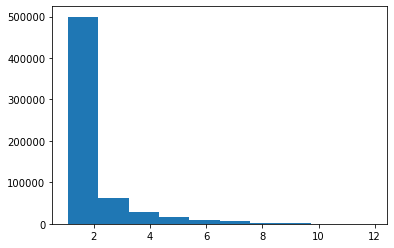

In [51]:
plt.hist((1/train_X_T_probs_lgbm))
plt.show()

## p(D=1|T=1) estimator

In [52]:
clf_D_given_T_lr = LogisticRegression(random_state=0, solver='liblinear', penalty='l1').fit(np.array(train_X_D_given_T), 
                                                                                 train_y_D_given_T)
test_y_D_given_T_proba=clf_D_given_T_lr.predict_proba(np.array(test_X_D_given_T))
print(f"AUC score with lr: {roc_auc_score(np.array(test_y_D_given_T), test_y_D_given_T_proba[:,1])}")

save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', 'clf_D_given_T_lr.pkl')
with open(f"{save_path}", "wb") as output_file:
    pickle.dump(clf_D_given_T_lr, output_file)

AUC score with lr: 0.8019435772927224


In [53]:
clf_D_given_T_lgbm = LGBMClassifier(random_state=0).fit(np.array(train_X_D_given_T), train_y_D_given_T)
test_y_D_given_T_proba=clf_D_given_T_lgbm.predict_proba(np.array(test_X_D_given_T))
print(f"AUC score with lgbm: {roc_auc_score(np.array(test_y_D_given_T), test_y_D_given_T_proba[:,1])}")

save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', 'clf_D_given_T_lgbm.pkl')
with open(f"{save_path}", "wb") as output_file:
    pickle.dump(clf_D_given_T_lgbm, output_file)

AUC score with lgbm: 0.8220645044692207


## p(D=1,T=1) estimator

In [61]:
clf_D_and_T_lr = LogisticRegression(random_state=0, solver='liblinear', penalty='l1').fit(np.array(train_X), 
                                                                                 train_y_D_and_T)
test_y_D_and_T_proba=clf_D_and_T_lr.predict_proba(np.array(test_X))
print(f"AUC score with lr : {roc_auc_score(np.array(test_y_D_and_T), test_y_D_and_T_proba[:,1])}")

save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', 'clf_D_and_T_lr.pkl')
with open(f"{save_path}", "wb") as output_file:
    pickle.dump(clf_D_and_T_lr, output_file)

AUC score with lr : 0.8449269174048857


In [62]:
clf_D_and_T_lgbm = LGBMClassifier(random_state=0).fit(np.array(train_X), train_y_D_and_T)
test_y_D_and_T_proba=clf_D_and_T_lgbm.predict_proba(np.array(test_X))
print(f"AUC score with lgbm: {roc_auc_score(np.array(test_y_D_and_T), test_y_D_and_T_proba[:,1])}")

save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', 'clf_D_and_T_lgbm.pkl')
with open(f"{save_path}", "wb") as output_file:
    pickle.dump(clf_D_and_T_lgbm, output_file)

AUC score with lgbm: 0.8633037562267756


## p(D=1|T=1)_ipw estimator

In [63]:
clf_D_given_T_lr_ipw = LogisticRegression(random_state=0, solver='liblinear', penalty='l1').fit(np.array(train_X_D_given_T), 
                                                            train_y_D_given_T, sample_weight=1/train_X_T_probs_lr)
test_y_D_given_T_proba=clf_D_given_T_lr_ipw.predict_proba(np.array(test_X_D_given_T))
print(f"AUC score with lr ipw: {roc_auc_score(np.array(test_y_D_given_T), test_y_D_given_T_proba[:,1])}")

save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', 'clf_D_given_T_lr_ipw.pkl')
with open(f"{save_path}", "wb") as output_file:
    pickle.dump(clf_D_given_T_lr_ipw, output_file)

AUC score with lr ipw: 0.8025398874060894


In [51]:
clf_D_given_T_lgbm_ipw = LGBMClassifier(random_state=0).fit(np.array(train_X_D_given_T), train_y_D_given_T,
                                                      sample_weight=1/train_X_T_probs_lgbm)
test_y_D_given_T_proba=clf_D_given_T_lgbm_ipw.predict_proba(np.array(test_X_D_given_T))
print(f"AUC score with lgbm ipw: {roc_auc_score(np.array(test_y_D_given_T), test_y_D_given_T_proba[:,1])}")

save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', 'clf_D_given_T_lgbm_ipw.pkl')
with open(f"{save_path}", "wb") as output_file:
    pickle.dump(clf_D_given_T_lgbm_ipw, output_file)

AUC score with lgbm ipw: 0.8195264463392868


## Heckman Correction

In [127]:
df_raw_sf.iloc[train_idxs].columns

Index(['suspect.height', 'suspect.weight', 'additional.report',
       'additional.investigation', 'additional.proximity',
       'additional.evasive', 'additional.associating', 'additional.direction',
       'additional.highcrime', 'additional.time',
       ...
       'suspect.eye_other', 'suspect.eye_pink', 'suspect.eye_two different',
       'suspect.eye_unknown', 'suspect.eye_violet', 'suspect.build_medium',
       'suspect.build_muscular', 'suspect.build_thin', 'suspect.build_unknown',
       'D_and_T'],
      dtype='object', length=285)

In [128]:
len(df_raw_sf.iloc[train_idxs].columns), len(features)

(285, 282)

In [129]:
res = Heckman(train_y_D.astype(float), np.array(df_raw_sf.iloc[train_idxs][["suspect.height","suspect.weight", 'suspect.eye_other', 'suspect.eye_pink', 'suspect.eye_two different',
       'suspect.eye_unknown', 'suspect.eye_violet', 'suspect.build_medium',
       'suspect.build_muscular', 'suspect.build_thin', 'suspect.build_unknown']].reset_index(drop=True)).astype(float), train_y_T.astype(float)).fit(method='twostep')
print(res.summary())

       Heckman Regression Results      
Dep. Variable:                        y
Model:                          Heckman
Method:                Heckman Two-Step
Date:                  Mon, 02 Jan 2023
Time:                          09:19:11
No. Total Obs.:                 1106542
No. Censored Obs.:               482881
No. Uncensored Obs.:             623661
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.702e-05      0.000     -0.132      0.895      -0.000       0.000
x2         -5.645e-05      0.000     -0.239      0.811      -0.001       0.000
x3             0.0045      0.003      1.396      0.163      -0.002       0.011
x4            -0.0214      0.071     -0.302      0.763      -0.161       0.118
x5             0.0023      0.009      0.266      0.790      -0.015       0.020
x6             0.0002      0.003      0.083      0.934      -0.005       0.006
x7      

In [138]:
probs=res.predict(np.array(df_raw_sf.iloc[test_idxs][["suspect.height","suspect.weight",'suspect.eye_other', 'suspect.eye_pink', 'suspect.eye_two different',
       'suspect.eye_unknown', 'suspect.eye_violet', 'suspect.build_medium',
       'suspect.build_muscular', 'suspect.build_thin', 'suspect.build_unknown']].reset_index(drop=True)).astype(float))

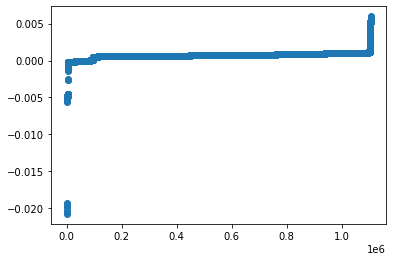

In [131]:
plt.scatter(np.arange(len(probs)), np.sort(probs))
plt.show()

In [136]:
y=train_y_D.astype(float)
x=np.array(df_raw_sf.iloc[train_idxs][["suspect.height","suspect.weight", 'suspect.eye_other', 'suspect.eye_pink', 'suspect.eye_two different',
       'suspect.eye_unknown', 'suspect.eye_violet', 'suspect.build_medium',
       'suspect.build_muscular', 'suspect.build_thin', 'suspect.build_unknown']].reset_index(drop=True)).astype(float)
w=train_y_T.astype(float)
# res_mle = Heckman(y,x,w).fit(method='mle')
# print(res_mle.summary())

In [110]:
np.unique(train_y_D.astype(float)), np.unique(train_y_T.astype(float))

(array([ 0.,  1., nan]), array([0., 1.]))

## Doubly Robust Estimation with sample splitting and pseudo outcome

In [ ]:
# split train data into two folds
# on first fold, estimate p(T) and p(D|T)

# on second fold, form dr pseudo outcome and estimate the DR learner
# repeat 1 and 2 by exchanging the folds

## DR with pseudo outcome

In [87]:
# form pseudo outcome
train_y_D_given_T_lr=clf_D_given_T_lr.predict_proba(np.array(train_X_D_given_T))[:,1]
train_y_D_given_T_lgbm=clf_D_given_T_lgbm.predict_proba(np.array(train_X_D_given_T))[:,1]
train_X_T_probs_lgbm=clf_T_lgbm.predict_proba(np.array(train_X_D_given_T))[:,1]
train_X_T_probs_lr=clf_T_lr.predict_proba(np.array(train_X_D_given_T))[:,1]
train_y_D_given_T_pseudo_dr_lgbm=((train_y_D_given_T-train_y_D_given_T_lgbm)/train_X_T_probs_lgbm) \
                                 + train_y_D_given_T_lgbm
train_y_D_given_T_pseudo_dr_lr=((train_y_D_given_T-train_y_D_given_T_lr)/train_X_T_probs_lr) \
                                 + train_y_D_given_T_lr

In [88]:
print(f"expected val:{train_y_D_given_T_pseudo_dr_lgbm.mean()}")

expected val:0.020475831251221824


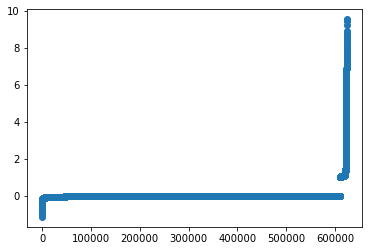

In [90]:
plt.scatter(np.arange(len(train_y_D_given_T_pseudo_dr_lgbm)), np.sort(train_y_D_given_T_pseudo_dr_lgbm))
plt.show()

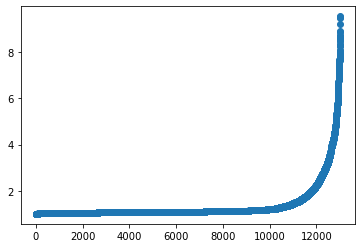

In [89]:
plt.scatter(np.arange(len(np.where(train_y_D_given_T_pseudo_dr_lgbm>1)[0])), np.sort(train_y_D_given_T_pseudo_dr_lgbm[np.where(train_y_D_given_T_pseudo_dr_lgbm>1)[0]]))
plt.show()

In [144]:
clf_D_given_T_lr_pseudo_dr = LinearRegression().fit(np.array(train_X_D_given_T), 
                                                                                 train_y_D_given_T_pseudo_dr_lr)
test_y_D_given_T_lr_pseudo_dr=clf_D_given_T_lr_pseudo_dr.predict(np.array(test_X_D_given_T))

save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', 'clf_D_given_T_lr_pseudo_dr.pkl')
with open(f"{save_path}", "wb") as output_file:
    pickle.dump(clf_D_given_T_lr_pseudo_dr, output_file)

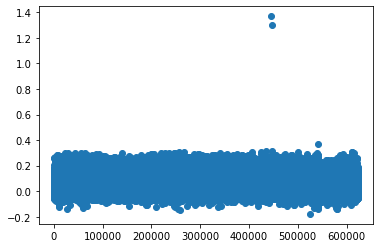

In [143]:
plt.scatter(np.arange(len(test_y_D_given_T_lr_pseudo_dr)), test_y_D_given_T_lr_pseudo_dr)
plt.show()

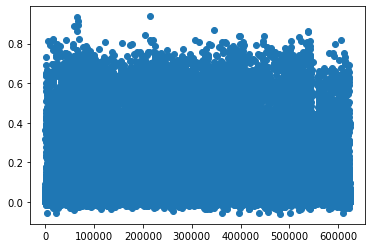

In [147]:
clf_D_given_T_lgbm_pseudo_dr = LGBMRegressor(random_state=0).fit(np.array(train_X_D_given_T), train_y_D_given_T_pseudo_dr_lgbm)
test_y_D_given_T_lgbm_pseudo_dr=clf_D_given_T_lgbm_pseudo_dr.predict(np.array(test_X_D_given_T))

plt.scatter(np.arange(len(test_y_D_given_T_lgbm_pseudo_dr)), test_y_D_given_T_lgbm_pseudo_dr)
plt.show()

save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', 'clf_D_given_T_lgbm_pseudo_dr.pkl')
with open(f"{save_path}", "wb") as output_file:
    pickle.dump(clf_D_given_T_lgbm_pseudo_dr, output_file)

## IPW with pseudo outcome

In [54]:
# form pseudo outcome
train_y_D_given_T_pseudo_ipw_lgbm=train_y_D_given_T/train_X_T_probs_lgbm
sum_ipw_weights_lgbm = train_y_D_given_T_pseudo_ipw_lgbm.sum()
print(f"sum_ipw_weights_lgbm : {sum_ipw_weights_lgbm}")
train_y_D_given_T_pseudo_ipw_lr=train_y_D_given_T/train_X_T_probs_lr
sum_ipw_weights_lr = train_y_D_given_T_pseudo_ipw_lr.sum()
print(f"sum_ipw_weights_lr : {sum_ipw_weights_lr}")

sum_ipw_weights_lgbm : 18375.139968506122
sum_ipw_weights_lr : 18561.318419750296


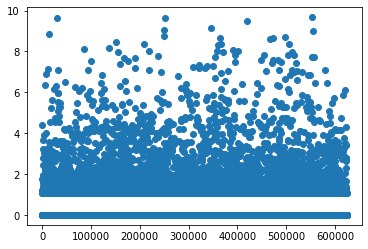

In [60]:
plt.scatter(np.arange(len(train_y_D_given_T_pseudo_ipw_lgbm)), train_y_D_given_T_pseudo_ipw_lgbm)
plt.show()

In [56]:
print(f"expected val:{train_y_D_given_T_pseudo_ipw_lgbm.mean()}")

expected val:0.02947123784431947


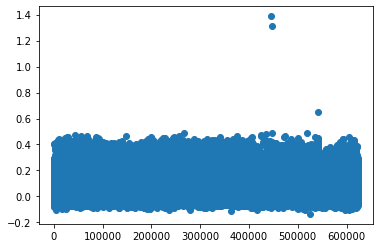

In [61]:
clf_D_given_T_lr_pseudo_ipw = LinearRegression().fit(np.array(train_X_D_given_T), train_y_D_given_T_pseudo_ipw_lr)
test_y_D_given_T_lr_pseudo_ipw = clf_D_given_T_lr_pseudo_ipw.predict(np.array(test_X_D_given_T))
# print(f"AUC score with lr: {roc_auc_score(np.array(test_y_D_given_T), test_y_D_given_T_proba[:,1])}")

plt.scatter(np.arange(len(test_y_D_given_T_lr_pseudo_ipw)), test_y_D_given_T_lr_pseudo_ipw)
plt.show()
save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', 'clf_D_given_T_lr_pseudo_ipw.pkl')
with open(f"{save_path}", "wb") as output_file:
    pickle.dump(clf_D_given_T_lr_pseudo_ipw, output_file)

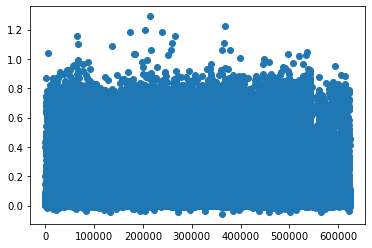

In [62]:
clf_D_given_T_lgbm_pseudo_ipw = LGBMRegressor(random_state=0).fit(np.array(train_X_D_given_T), train_y_D_given_T_pseudo_ipw_lgbm)
test_y_D_given_T_lgbm_pseudo_ipw=clf_D_given_T_lgbm_pseudo_ipw.predict(np.array(test_X_D_given_T))
# print(f"AUC score with lr: {roc_auc_score(np.array(test_y_D_given_T), test_y_D_given_T_proba[:,1])}")

plt.scatter(np.arange(len(test_y_D_given_T_lgbm_pseudo_ipw)), test_y_D_given_T_lgbm_pseudo_ipw)
plt.show()

save_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk', 'clf_D_given_T_lgbm_pseudo_ipw.pkl')
with open(f"{save_path}", "wb") as output_file:
    pickle.dump(clf_D_given_T_lgbm_pseudo_ipw, output_file)

## Find correlation between the probs from different estimators

In [65]:
def getPred_fromProb(prob, thresh=0.5):
    if prob>=thresh:
        return 1.0
    else:
        return 0.0
    
def getMetrics(labels, prob):
    PR = average_precision_score(labels, prob)
    auc_score = roc_auc_score(labels, prob)
    print(f"auc_score:{auc_score}")
    preds=np.vectorize(getPred_fromProb)(prob)
    balanced_accr = balanced_accuracy_score(labels, preds)
    cr = classification_report(labels, preds)
    return auc_score, PR, balanced_accr, cr

def loadModelData(m, t):
    X=np.array(test_X)
    assert m in ['LogisticRegression', 'LGBM']
    assert t in ['T', 'D|T', 'D_and_T', 'D|T_ipw']
    if t=='T':
        y=df_raw_sf.iloc[test_idxs]['T'].values
        if m=='LogisticRegression':
            clf=clf_T_lr
        elif m=='LGBM':
            clf=clf_T_lgbm
    elif t=='D|T':
        y=df_raw_sf.iloc[test_idxs]['D'].values
        if m=='LogisticRegression':
            clf=clf_D_given_T_lr
        elif m=='LGBM':
            clf=clf_D_given_T_lgbm
    elif t=='D|T_ipw':   
        y=df_raw_sf.iloc[test_idxs]['D'].values
        if m=='LogisticRegression':
            clf = clf_D_given_T_lr_ipw
        elif m=='LGBM':
            clf = clf_D_given_T_lgbm_ipw
    elif t=='D_and_T':
        y=df_raw_sf.iloc[test_idxs]['D_and_T'].values
        if m=='LogisticRegression':
            clf=clf_D_and_T_lr
        elif m=='LGBM':
            clf=clf_D_and_T_lgbm
    return clf, y, X

In [66]:
def getCorr(models, tasks, dict_df_labels, dict_df_probs, dict_models, df_pp, calibrate=False,**kwargs):
    epsilon = kwargs.get('epsilon')
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
    for col, m in enumerate(models):
        dict_df_labels[m]= pd.DataFrame([])
        dict_df_probs[m]= pd.DataFrame([])
        dict_models[m]= {}
        for row, t in enumerate(tasks):
            model , labels, X = loadModelData(m, t)
            dict_models[m][str(t)]=model
            dict_df_labels[m][str(t)]=labels
            probs = model.predict_proba(X)[:,1]
            dict_df_probs[m][str(t)]=probs
            probs = probs[~np.isnan(labels)]
            labels = labels[~np.isnan(labels)]
            auc_score, pr_score, balanced_acc = getMetrics(labels, probs)[:3]
            print(f"classification report for model {m}, task {t}: \n {getMetrics(labels, probs)[3]}")
            df_pp=df_pp.append({'AUC' :auc_score ,'PR':pr_score,'BalancedAcc':balanced_acc, 'modelName':m,'rowName':t},ignore_index=True)
            
        # get the correlation
        T_probs = dict_df_probs[m]['T']
        D_given_T_probs = dict_df_probs[m]['D|T']
        D_and_T_probs = dict_df_probs[m]['D_and_T']

        print(f"T and D|T probs for model {m}: {stats.spearmanr(T_probs, D_given_T_probs)}")
        print(f"T and D,T probs for model {m}: {stats.spearmanr(T_probs, D_and_T_probs)}")
        print(f"D,T and D|T probs for model {m}: {stats.spearmanr(D_and_T_probs, D_given_T_probs)}")
        ax[0,col].scatter(D_given_T_probs, T_probs, s=5)
        ax[1,col].scatter(D_and_T_probs, T_probs, s=5)
        ax[2,col].scatter(D_and_T_probs, D_given_T_probs, s=5)
        ax[0,col].set_title(f"{m}")
    ax[0,0].set_ylabel('p(T=1|X)')  
    ax[1,0].set_ylabel('p(T=1|X)')   
    ax[2,0].set_xlabel('p(D=1,T=1|X)')  
    ax[0,0].set_xlabel('p(D=1|T=1,X)')
    ax[1,0].set_xlabel('p(D=1,T=1,X)')
    ax[2,0].set_ylabel('p(D=1|T=1,X)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()
    plt.close()
    return dict_df_labels, dict_df_probs, dict_models, df_pp

In [67]:
def plotCorr(models, dict_df_probs, title):
    fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(15,9))
    plt.suptitle(str(title))
    
    for i, m in enumerate(models):
        df = dict_df_probs[m].copy()
        df = df.rename(columns={'T': 'p(T=1|X)', 'D|T': 'p(D=1|T=1,X)', 
        'D_and_T':'p(D=1,T=1|X)', 'D|T_ipw':'p(D=1|T=1,X)_ipw'})
        corr_mat = df.corr(method='spearman')
        assert np.all(np.linalg.eigvals(corr_mat)>0.0)
        mask = np.zeros_like(corr_mat, dtype=bool)
        mask[np.triu_indices_from(mask, k=1)] = True
        if i!=2:
            g1=sns.heatmap(corr_mat, mask=mask, cmap="Blues", annot=True, ax=ax1[i], cbar=False, annot_kws={"fontsize":20})
        else:
            g1=sns.heatmap(corr_mat, mask=mask, cmap="Blues", annot=True, ax=ax1[i], annot_kws={"fontsize":20})
        g1.set_ylabel('')
        g1.set_xlabel('')
        if i!=0:
            g1.set_yticks([])
        g1.set_title(str(m))
        g1.tick_params(axis='both', which='major', labelsize=15, rotation=45)
    fig1.tight_layout()
    fig1.subplots_adjust(top=0.85)
    plt.show()

auc_score:0.8175481998261711
auc_score:0.8175481998261711
classification report for model LogisticRegression, task T: 
               precision    recall  f1-score   support

       False       0.70      0.72      0.71    482881
        True       0.78      0.76      0.77    623661

    accuracy                           0.74   1106542
   macro avg       0.74      0.74      0.74   1106542
weighted avg       0.74      0.74      0.74   1106542

auc_score:0.8019435772927224
auc_score:0.8019435772927224
classification report for model LogisticRegression, task D|T: 
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    610820
         1.0       0.61      0.08      0.14     12841

    accuracy                           0.98    623661
   macro avg       0.80      0.54      0.57    623661
weighted avg       0.97      0.98      0.97    623661

auc_score:0.8449269174048857
auc_score:0.8449269174048857
classification report for model LogisticRegres

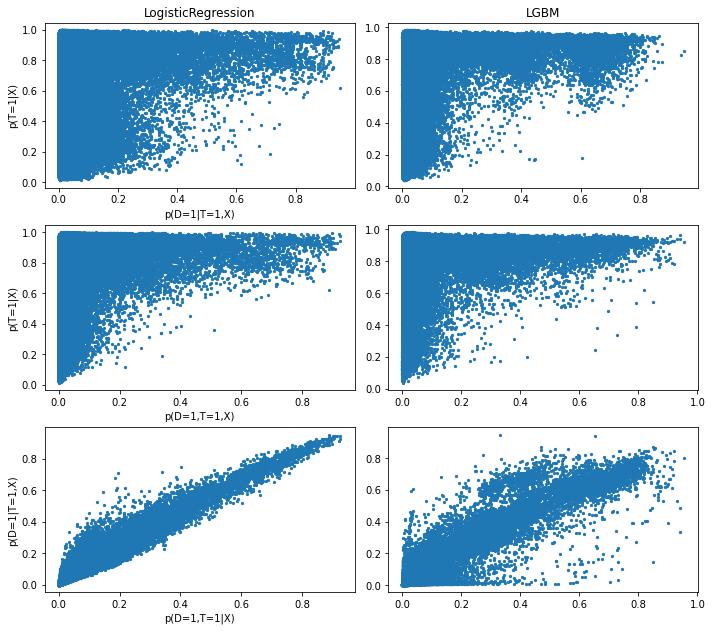

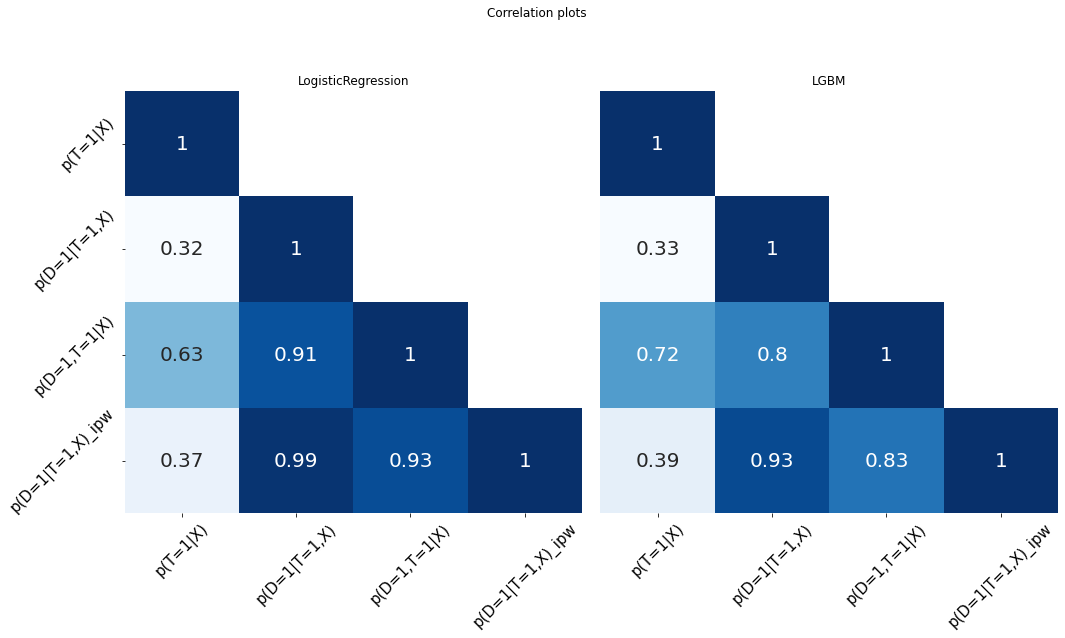

In [68]:
models=['LogisticRegression', 'LGBM']
tasks=['T', 'D|T', 'D_and_T', 'D|T_ipw']
dict_df_labels={}
dict_df_probs={}
dict_df_ids={}
dict_models={}
df_pp=pd.DataFrame({'AUC' : [],'PR':[],'BalancedAcc':[],'modelName':[],'rowName':[]})
dict_df_labels, dict_df_probs, dict_models, df_pp = getCorr(models, tasks, dict_df_labels, dict_df_probs
                                                            , dict_models, df_pp, calibrate=False)
title='Correlation plots'
plotCorr(models, dict_df_probs, title)

In [69]:
df_pp

,AUC,PR,BalancedAcc,modelName,rowName
0,0.817548,0.851647,0.740905,LogisticRegression,T
1,0.801944,0.243294,0.539262,LogisticRegression,D|T
2,0.844927,0.211174,0.529540,LogisticRegression,D_and_T
3,0.802540,0.241529,0.531332,LogisticRegression,D|T_ipw
4,0.832573,0.865754,0.753782,LGBM,T
5,0.822065,0.269246,0.577797,LGBM,D|T
6,0.863304,0.232796,0.564177,LGBM,D_and_T
7,0.820131,0.263038,0.574318,LGBM,D|T_ipw
